# Indicators of Heart Disase (2022 Update)
`Data Set link: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease`

# Import & Datensatz

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, true_positive_rate,false_positive_rate

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np

In [38]:
df = pd.read_csv("heart_2020_cleaned.csv")
df_orginal = df.copy()

In [39]:
styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.600000,Yes,No,No,3.000000,30.000000,No,Female,55-59,White,Yes,Yes,Very good,5.000000,Yes,No,Yes
1,No,20.340000,No,No,Yes,0.000000,0.000000,No,Female,80 or older,White,No,Yes,Very good,7.000000,No,No,No
2,No,26.580000,Yes,No,No,20.000000,30.000000,No,Male,65-69,White,Yes,Yes,Fair,8.000000,Yes,No,No
3,No,24.210000,No,No,No,0.000000,0.000000,No,Female,75-79,White,No,No,Good,6.000000,No,No,Yes
4,No,23.710000,No,No,No,28.000000,0.000000,Yes,Female,40-44,White,No,Yes,Very good,8.000000,No,No,No
5,Yes,28.870000,Yes,No,No,6.000000,0.000000,Yes,Female,75-79,Black,No,No,Fair,12.000000,No,No,No
6,No,21.630000,No,No,No,15.000000,0.000000,No,Female,70-74,White,No,Yes,Fair,4.000000,Yes,No,Yes
7,No,31.640000,Yes,No,No,5.000000,0.000000,Yes,Female,80 or older,White,Yes,No,Good,9.000000,Yes,No,No
8,No,26.450000,No,No,No,0.000000,0.000000,No,Female,80 or older,White,"No, borderline diabetes",No,Fair,5.000000,No,Yes,No
9,No,40.690000,No,No,No,0.000000,0.000000,Yes,Male,65-69,White,No,Yes,Good,10.000000,No,No,No


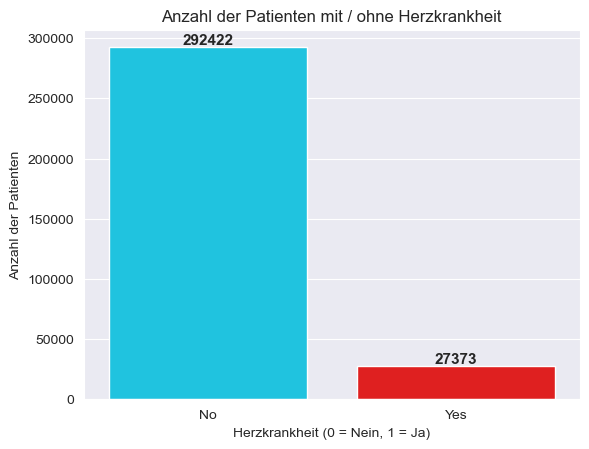

Anzahl der Zeilen (Patienten): 319795
Anzahl der Spalten (Features): 18


In [40]:
ax = sns.countplot(x='HeartDisease', hue='HeartDisease', data=df, palette=['#00d9ff', '#ff0000'], legend=False)

plt.title('Anzahl der Patienten mit / ohne Herzkrankheit')
plt.xlabel('Herzkrankheit (0 = Nein, 1 = Ja)')
plt.ylabel('Anzahl der Patienten')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

plt.show()
print(f"Anzahl der Zeilen (Patienten): {df.shape[0]}")
print(f"Anzahl der Spalten (Features): {df.shape[1]}")

# Daten Vorverarbeitung

## Duplikate & Fehlende Werte

In [41]:
duplikate_df = df[df.duplicated(keep=False)]

anzahl_duplikate = len(duplikate_df)
gesamt = len(df)
prozent_duplikate = (anzahl_duplikate / gesamt) * 100

# Verteilung HeartDisease in den Duplikaten
verteilung_duplikate = duplikate_df['HeartDisease'].value_counts(normalize=True) * 100

# Verteilung HeartDisease im gesamten DataFrame
verteilung_gesamt = df['HeartDisease'].value_counts(normalize=True) * 100

# Ausgabe
print("Gesamtzeilen:", gesamt)
print("Anzahl mehrfach vorkommender Zeilen:", anzahl_duplikate)
print(f"Prozent mehrfach vorkommend: {prozent_duplikate:.2f}%\n")

print("Verteilung von Heartdisease innerhalb der Duplikate:")
if not verteilung_duplikate.empty:
    for wert, proz in verteilung_duplikate.items():
        print(f"  {wert}: {proz:.2f}%")
else:
    print("    - - -")

print("\nGesamtverteilung HeartDisease:")
for wert, proz in verteilung_gesamt.items():
    print(f"  {wert}: {proz:.2f}%")

Gesamtzeilen: 319795
Anzahl mehrfach vorkommender Zeilen: 29930
Prozent mehrfach vorkommend: 9.36%

Verteilung von Heartdisease innerhalb der Duplikate:
  No: 99.27%
  Yes: 0.73%

Gesamtverteilung HeartDisease:
  No: 91.44%
  Yes: 8.56%


In [42]:
df = df.drop_duplicates()

In [43]:
print("Fehlende Werte: ")
print(df.isnull().sum())

Fehlende Werte: 
HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64


## Typprüfung

In [44]:
def check_values(column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte '{column_type}' nicht im Datensatz gefunden.")
        return

    values = df[column_type].dropna().unique()
    invalid = set(values).difference(set(valid_values))
    if invalid:
         print(f" Ungültige Werte in Spalte '{column_type}': {invalid} ")
    else:
        print(f"Alle Werte in Spalte '{column_type}' sind gültig ")

valid_values_dict = {
    "Sex": {'Male', 'Female'},
    "Smoking": {'Yes', 'No'},
    "AlcoholDrinking": {'Yes', 'No'},
    "Diabetic": {
        'Yes', 'No',
        'No, borderline diabetes',
        'Yes (during pregnancy)'
    },
    "GenHealth": {'Excellent', 'Very good', 'Good', 'Fair', 'Poor'},
    "Race": {
        'White', 'Black', 'Asian',
        'American Indian/Alaskan Native',
        'Other', 'Hispanic'
    },
    "AgeCategory": {
        '18-24', '25-29', '30-34', '35-39', '40-44', '45-49',
        '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older'
    },
    "Asthma": {'Yes', 'No'},
    "KidneyDisease": {'Yes', 'No'},
    "SkinCancer": {'Yes', 'No'},
    "Stroke": {'Yes', 'No'},
    "DiffWalking": {'Yes', 'No'},
    "PhysicalActivity": {'Yes', 'No'},
    "HeartDisease": {'Yes', 'No'}
}


def check_if_numeric (column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte {column_type}' nicht im Datensatz gefunden.")
        return
    else:
        non_numeric = df[column_type].dropna().apply(lambda x: not isinstance(x, (int, float)))
        if non_numeric.any():
            count_invalid = non_numeric.sum()
            print(f"{count_invalid} nicht numerische Werte in Spalte '{column_type}'")
            print(f"Beispiele: {df[column_type][non_numeric].unique()[:5]}")
        else:
            print(f"Alle Werte in Spalte '{column_type}' sind numerisch.")

numeric_columns = [
    'BMI',
    'PhysicalHealth',
    'MentalHealth',
    'SleepTime',
]


# Anwendung:
for column, valid_set in valid_values_dict.items():
    check_values(column, valid_set)

for col in numeric_columns:
    check_if_numeric(col, numeric_columns)

Alle Werte in Spalte 'Sex' sind gültig 
Alle Werte in Spalte 'Smoking' sind gültig 
Alle Werte in Spalte 'AlcoholDrinking' sind gültig 
Alle Werte in Spalte 'Diabetic' sind gültig 
Alle Werte in Spalte 'GenHealth' sind gültig 
Alle Werte in Spalte 'Race' sind gültig 
Alle Werte in Spalte 'AgeCategory' sind gültig 
Alle Werte in Spalte 'Asthma' sind gültig 
Alle Werte in Spalte 'KidneyDisease' sind gültig 
Alle Werte in Spalte 'SkinCancer' sind gültig 
Alle Werte in Spalte 'Stroke' sind gültig 
Alle Werte in Spalte 'DiffWalking' sind gültig 
Alle Werte in Spalte 'PhysicalActivity' sind gültig 
Alle Werte in Spalte 'HeartDisease' sind gültig 
Alle Werte in Spalte 'BMI' sind numerisch.
Alle Werte in Spalte 'PhysicalHealth' sind numerisch.
Alle Werte in Spalte 'MentalHealth' sind numerisch.
Alle Werte in Spalte 'SleepTime' sind numerisch.


## Unrealistische Werte
Unrealistische Werte werden in diesem Datensatz einfach entfernt, da dies aufgrund der vielen Daten kein Problem ist

In [45]:
print(f"Anzahl an Zeilen: {len(df)}")

def check_unrealistic_values(columnName, min_val, max_val):
    series = df[columnName]
    _df = df[(df[columnName] >= min_val) & (df[columnName] <= max_val)]
    invalid = series[(series < min_val) | (series > max_val)]
    print(f"{columnName}: {len(invalid)} Werte außerhalb des akzeptieren Bereichs '{min_val}-{max_val}'")
    return _df


df = check_unrealistic_values('BMI', 12, 70)
df = check_unrealistic_values('SleepTime', 2, 18)


print(f"Neue Anzahl an Zeilen: {len(df)}")

Anzahl an Zeilen: 301717
BMI: 129 Werte außerhalb des akzeptieren Bereichs '12-70'
SleepTime: 662 Werte außerhalb des akzeptieren Bereichs '2-18'
Neue Anzahl an Zeilen: 300926


## Bias/ Korrelation

Altersverteilung
count     300926
unique        13
top        65-69
freq       31598
Name: AgeCategory, dtype: object


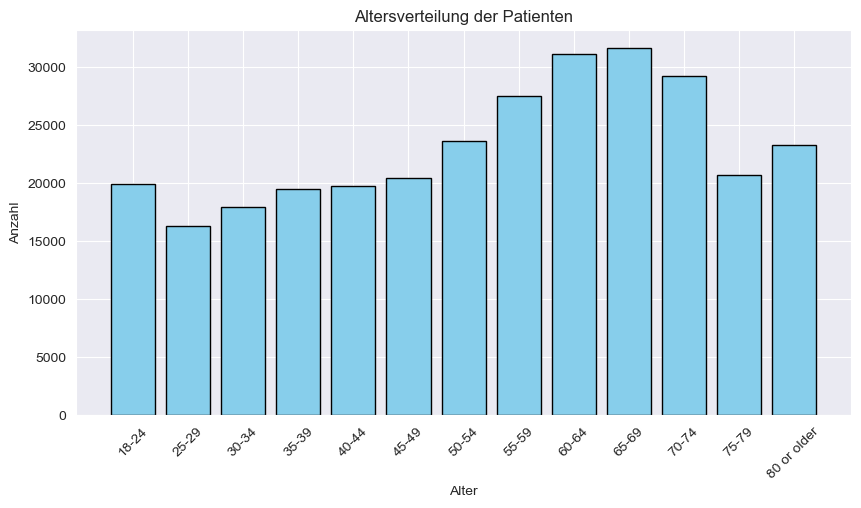

In [46]:
print("Altersverteilung")
print(df['AgeCategory'].describe())

age_order = [
    '18-24', '25-29', '30-34', '35-39', '40-44',
    '45-49', '50-54', '55-59', '60-64', '65-69',
    '70-74', '75-79', '80 or older'
]

age_counts = df['AgeCategory'].value_counts().reindex(age_order)

plt.figure(figsize=(10,5))
plt.bar(age_counts.index, age_counts.values, color='skyblue', edgecolor='black')
plt.title('Altersverteilung der Patienten')
plt.xlabel('Alter')
plt.ylabel('Anzahl')
plt.xticks(rotation=45)
plt.show()

Geschlechterverteilung
Female: 159282 Patienten (52.93%)
Male: 141644 Patienten (47.07%)


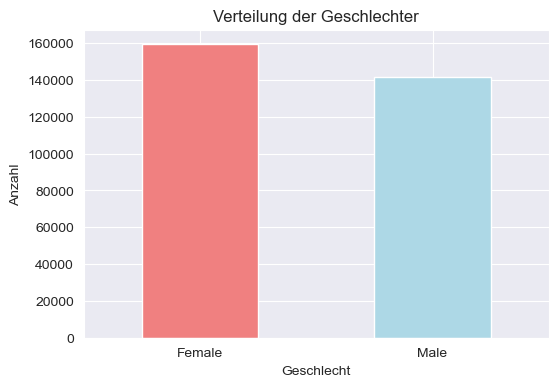

In [47]:

print("Geschlechterverteilung")
gender_counts = df['Sex'].value_counts()
gender_percent = df['Sex'].value_counts(normalize=True) * 100

for sex in gender_counts.index:
    print(f"{sex}: {gender_counts[sex]} Patienten ({gender_percent[sex]:.2f}%)")

plt.figure(figsize=(6,4))
gender_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Verteilung der Geschlechter')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.show()


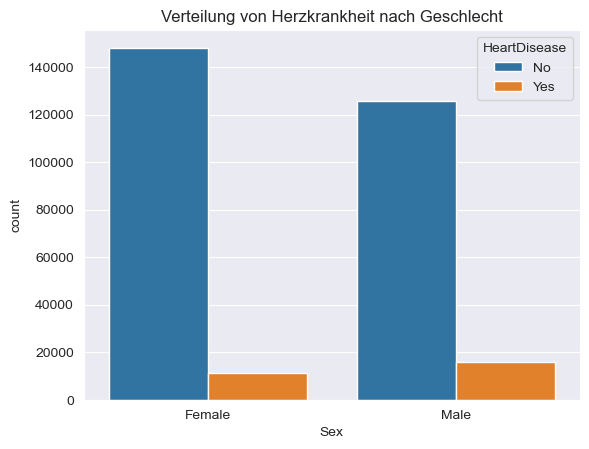

HeartDisease        No       Yes
Sex                             
Female        0.929885  0.070115
Male          0.887083  0.112917


In [48]:
sns.countplot(data=df, x='Sex', hue='HeartDisease')
plt.title("Verteilung von Herzkrankheit nach Geschlecht")
plt.show()

print(df.groupby("Sex")["HeartDisease"].value_counts(normalize=True).unstack())


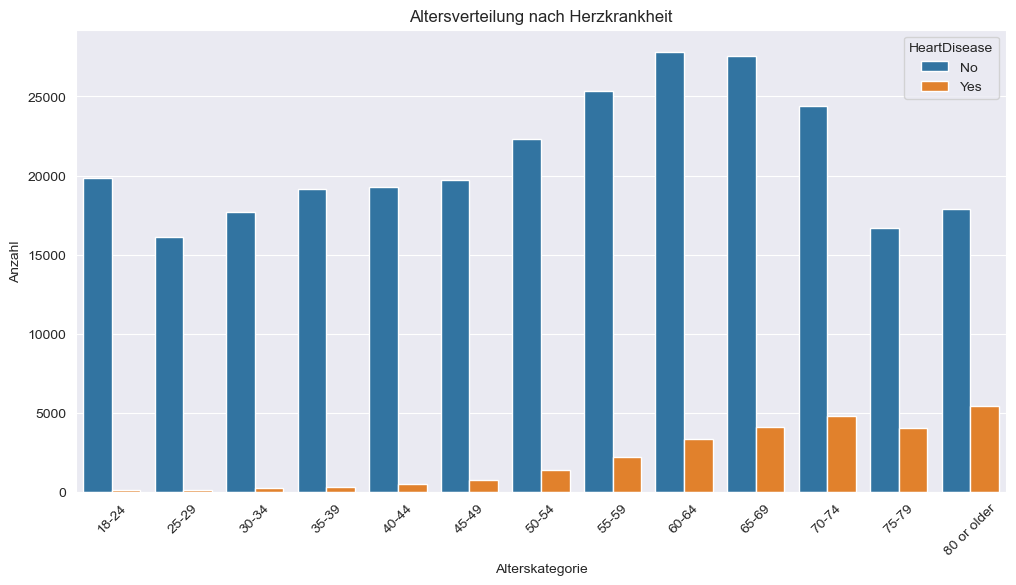

AgeCategory
18-24           0.63%
25-29           0.82%
30-34           1.25%
35-39           1.51%
40-44           2.45%
45-49           3.61%
50-54           5.81%
55-59           7.95%
60-64          10.62%
65-69          12.86%
70-74          16.45%
75-79          19.42%
80 or older    23.23%
Name: HeartDisease, dtype: object


In [49]:

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='AgeCategory', hue='HeartDisease', order=age_order)
plt.title("Altersverteilung nach Herzkrankheit")
plt.xlabel("Alterskategorie")
plt.ylabel("Anzahl")
plt.xticks(rotation=45)
plt.show()

# Anteil der 'Yes'-Werte pro Alterskategorie
heart_disease_by_age = df.groupby("AgeCategory")["HeartDisease"].apply(lambda x: (x == "Yes").mean())

# Optionale Ausgabe in Prozent:
print(heart_disease_by_age.apply(lambda x: f"{x*100:.2f}%"))


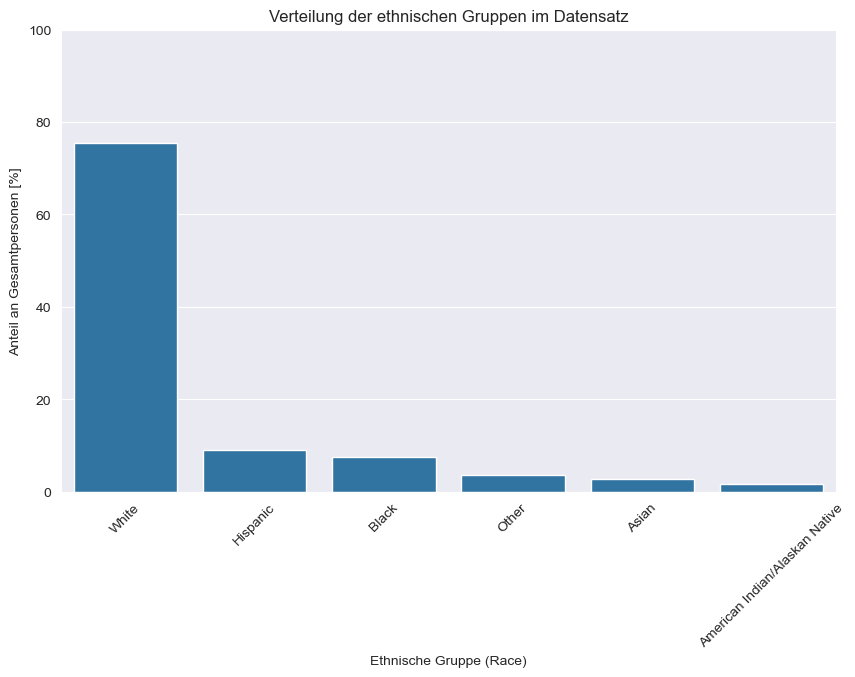

In [50]:
# Verteilung von Race
race_counts = df["Race"].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=race_counts.index, y=race_counts.values)
plt.title("Verteilung der ethnischen Gruppen im Datensatz")
plt.xlabel("Ethnische Gruppe (Race)")
plt.ylabel("Anteil an Gesamtpersonen [%]")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.show()

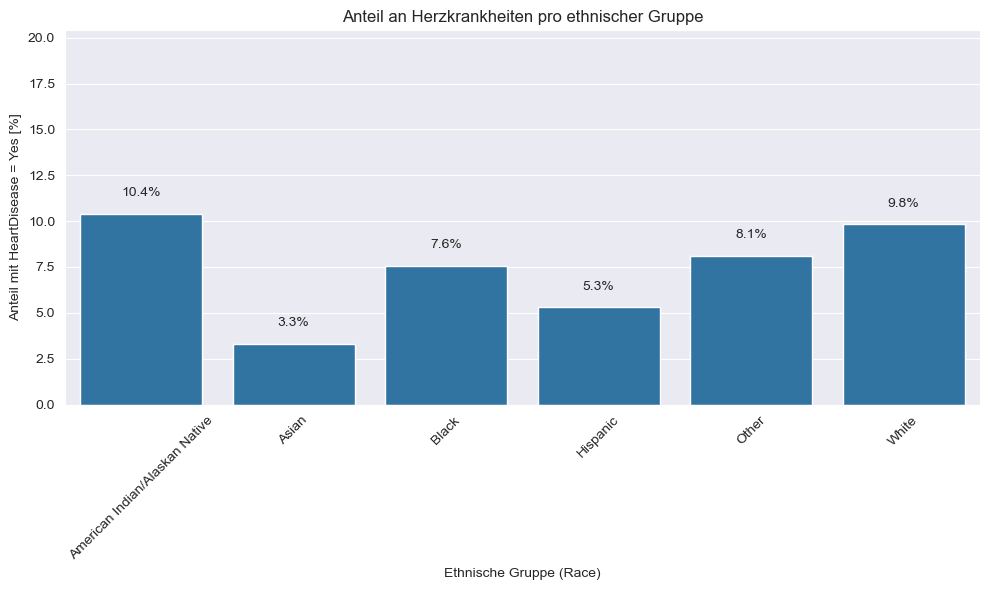

In [51]:

heart_disease_rates = df.groupby("Race")["HeartDisease"].apply(lambda x: (x == "Yes").mean()) * 100

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=heart_disease_rates.index, y=heart_disease_rates.values)

# Prozentzahlen über den Balken anzeigen
for i, value in enumerate(heart_disease_rates.values):
    ax.text(i, value + 0.8, f"{value:.1f}%", ha='center', va='bottom', fontsize=10)

plt.title("Anteil an Herzkrankheiten pro ethnischer Gruppe")
plt.xlabel("Ethnische Gruppe (Race)")
plt.ylabel("Anteil mit HeartDisease = Yes [%]")
plt.xticks(rotation=45)
plt.ylim(0, heart_disease_rates.max() + 10)
plt.tight_layout()
plt.show()

In [52]:
df = df.drop(columns=['Race'])

## Binärisierung

In [53]:
binary_map = {"No": 0, "Yes": 1}
binary_columns = ["HeartDisease","Smoking", "AlcoholDrinking", "Stroke", "DiffWalking",
                  "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]

for col in binary_columns:
    df[col] = df[col].map(binary_map)

df["Diabetic"] = df["Diabetic"].apply(lambda x: 0 if x == "No" else 1)


genhealth_map = {
        'Excellent': 4,
        'Very good': 3,
        'Good': 2,
        'Fair': 1,
        'Poor': 0
    }
df["GenHealth"] = df["GenHealth"].map(genhealth_map)
df["Sex"] = df["Sex"].map({"Female": 0, "Male": 1})

def age_to_mid(age):
        if "or older" in age:
            return 85
        low, high = map(int, age.split("-"))
        return (low + high) / 2

df["Age"] = df["AgeCategory"].apply(age_to_mid)
df.drop("AgeCategory", axis=1, inplace=True)

## Feauture Engineering

In [54]:
def bmi_category_code(bmi):
    if bmi < 18.5:
        return 15.5      # Untergewicht
    elif bmi < 25:
        return 22.5  # Normalgewicht
    elif bmi < 30:
        return 27.5  # Präadipositas
    elif bmi < 35:
        return 32.5  # Adipositas Grad I
    elif bmi < 40:
        return 37.5  # Adipositas Grad II
    else:
        return 55  # Adipositas Grad III

df['BMI'] = df['BMI'].apply(bmi_category_code)

## Skalierung

In [55]:
# Skalierung
scaler = MinMaxScaler()
scale_cols = ["BMI", "PhysicalHealth", "MentalHealth", "SleepTime", "Age"]
df[scale_cols] = scaler.fit_transform(df[scale_cols])

## Daten nach der Voverarbeitung

In [56]:
styled_df_after = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df_after

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Age
0,0,0.000000,1,0,0,0.100000,1.000000,0,0,1,1,3,0.187500,1,0,1,0.562500
1,0,0.177215,0,0,1,0.000000,0.000000,0,0,0,1,3,0.312500,0,0,0,1.000000
2,0,0.303797,1,0,0,0.666667,1.000000,0,1,1,1,1,0.375000,1,0,0,0.718750
3,0,0.177215,0,0,0,0.000000,0.000000,0,0,0,0,2,0.250000,0,0,1,0.875000
4,0,0.177215,0,0,0,0.933333,0.000000,1,0,0,1,3,0.375000,0,0,0,0.328125
5,1,0.303797,1,0,0,0.200000,0.000000,1,0,0,0,1,0.625000,0,0,0,0.875000
6,0,0.177215,0,0,0,0.500000,0.000000,0,0,0,1,1,0.125000,1,0,1,0.796875
7,0,0.430380,1,0,0,0.166667,0.000000,1,0,1,0,2,0.437500,1,0,0,1.000000
8,0,0.303797,0,0,0,0.000000,0.000000,0,0,1,0,1,0.187500,0,1,0,1.000000
9,0,1.000000,0,0,0,0.000000,0.000000,1,1,0,1,2,0.500000,0,0,0,0.718750


## Undersampling

In [57]:
from imblearn.under_sampling import RandomUnderSampler

X = df.drop('HeartDisease', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['HeartDisease']

target_counts = {0: 50000, 1: sum(y == 1)}  # 1 bleibt unverändert

rus = RandomUnderSampler(sampling_strategy=target_counts, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(y_resampled.value_counts())


HeartDisease
0    50000
1    27162
Name: count, dtype: int64


# Machine Learning

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

## Logistische Regression
Logistische Regression mit Balanced, zum ausgleich der wenigen erkankten

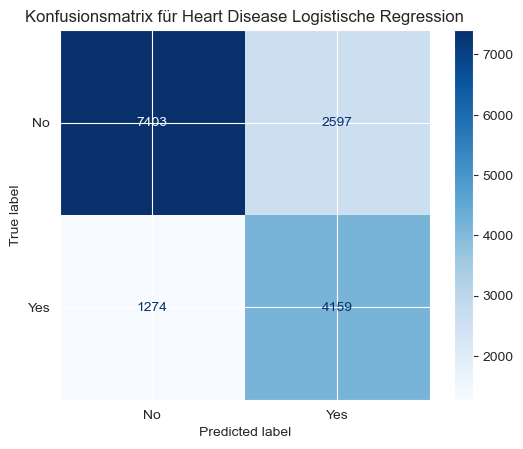

Accuracy: 0.7491738482472624
Precision: 0.6156009473060983
Recall: 0.7655070863243144
F1-Score: 0.6824185741242104


In [59]:
X = df.drop('HeartDisease', axis=1)
X = pd.get_dummies(X, drop_first=True)

y = df['HeartDisease']

modelLogistic = LogisticRegression(max_iter=1000, class_weight='balanced')
modelLogistic.fit(X_train, y_train)

y_pred_lr = modelLogistic.predict(X_test)

cm = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression')
plt.show()

accuracy = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_lr)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_lr)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_lr)
print("F1-Score:", f1)

### Fairness nach Geschlecht

In [60]:
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_lr, sensitive_features=sensitive_feature)

print("Fairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_lr, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.765102   0.577838  0.679358  0.624499        0.338037
1    0.733792   0.638684  0.823240  0.719312        0.534072
Demographic Parity Difference: 0.196


### Relevanz der Daten nach Permutation

Age: 0.0956 ± 0.0033
GenHealth: 0.0331 ± 0.0034
Sex: 0.0178 ± 0.0017
Stroke: 0.0108 ± 0.0010
KidneyDisease: 0.0031 ± 0.0007
Diabetic: 0.0027 ± 0.0011
Smoking: 0.0019 ± 0.0011
PhysicalHealth: 0.0013 ± 0.0006
Asthma: 0.0010 ± 0.0005
AlcoholDrinking: 0.0009 ± 0.0004
DiffWalking: 0.0005 ± 0.0008
MentalHealth: 0.0005 ± 0.0004
PhysicalActivity: 0.0003 ± 0.0003
BMI: -0.0001 ± 0.0006
SleepTime: -0.0003 ± 0.0005
SkinCancer: -0.0009 ± 0.0004


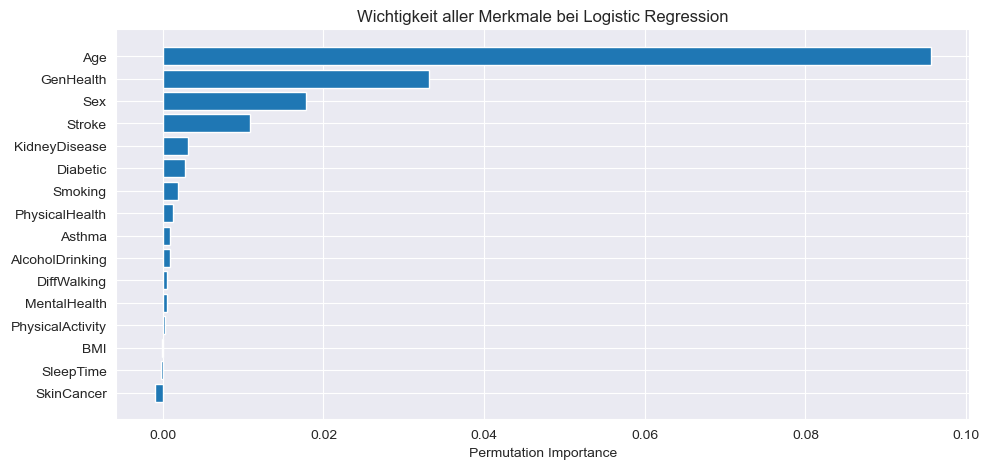

In [61]:
result = permutation_importance(modelLogistic, X_test, y_test, n_repeats=15, random_state=42, scoring='accuracy')
sorted_idx = result.importances_mean.argsort()[::-1]

for i in sorted_idx:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

plt.figure(figsize=(10, len(X_test.columns) * 0.3))
plt.barh(X_test.columns[sorted_idx][::-1], result.importances_mean[sorted_idx][::-1])
plt.xlabel("Permutation Importance")
plt.title("Wichtigkeit aller Merkmale bei Logistic Regression")
plt.tight_layout()
plt.show()

### SHAP Analyse

In [62]:
explainer_lr = shap.Explainer(modelLogistic, X_train)
shap_values_lr = explainer_lr(X_test)

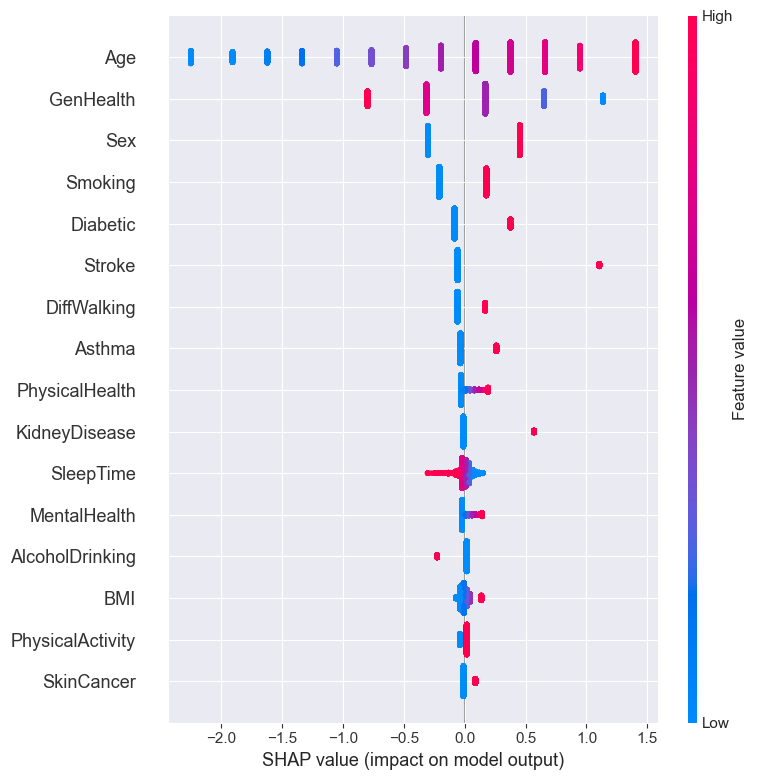

In [63]:
shap.summary_plot(shap_values_lr, X_test)

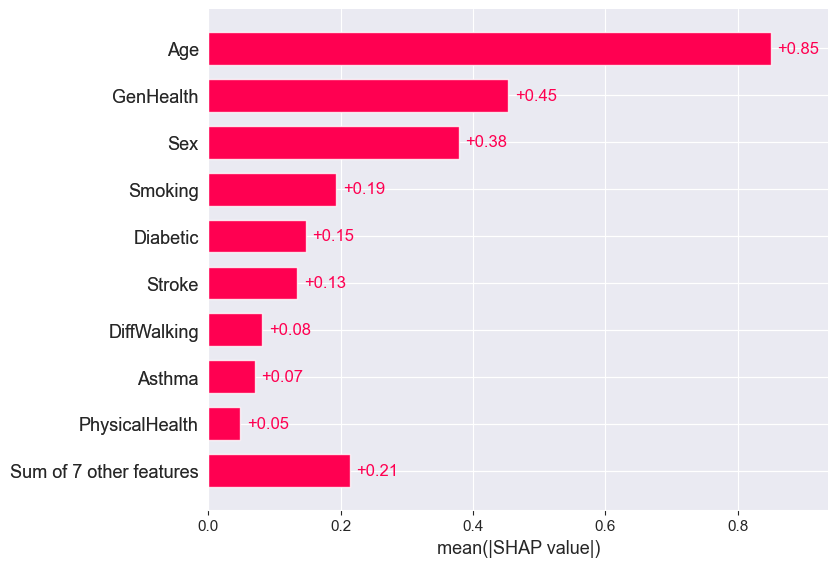

In [64]:
shap.plots.bar(shap_values_lr)

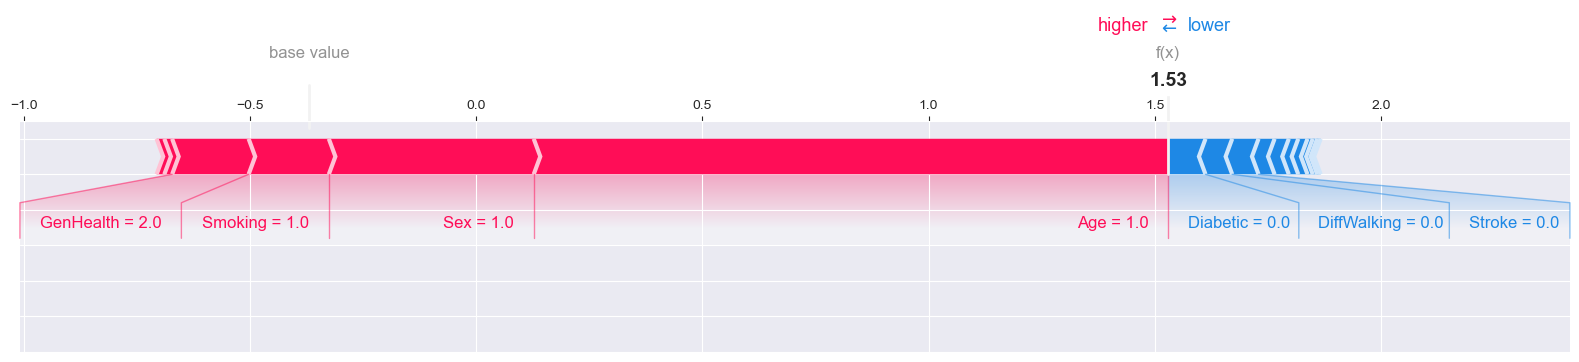

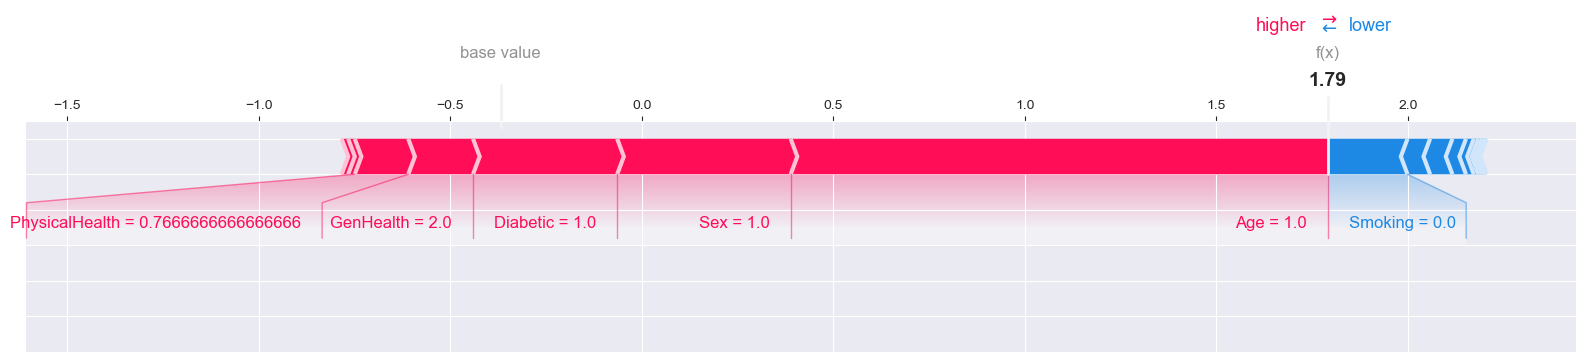

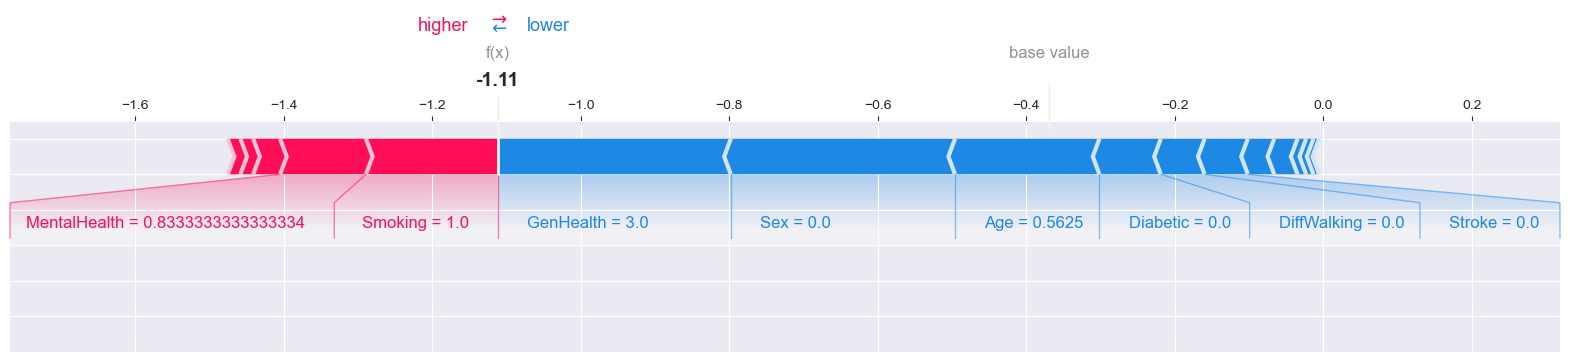

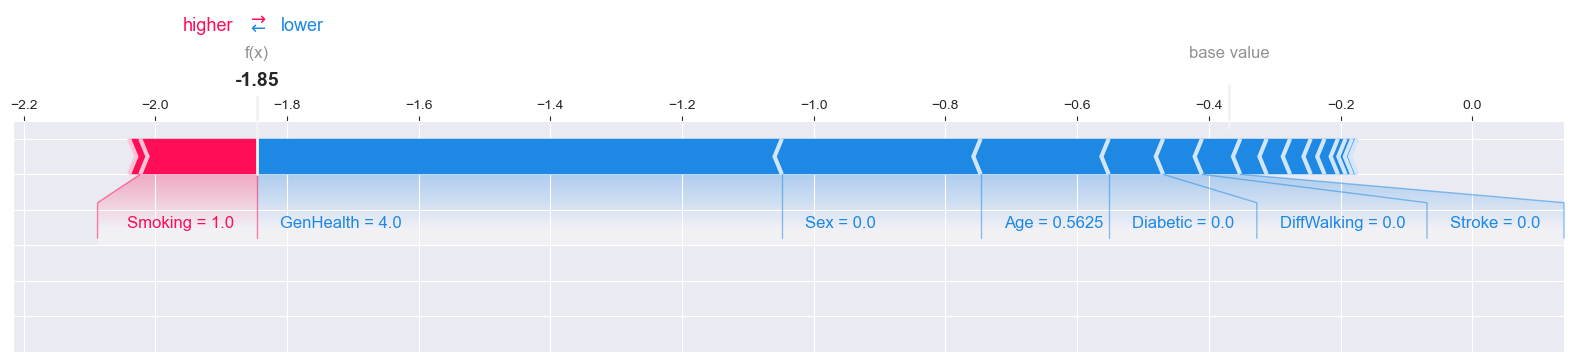

In [65]:
indices = [7, 8, 9, 10]
for index in indices:
    shap.plots.force(shap_values_lr[index], matplotlib=True)

## Random Forrest

In [66]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)
best_forest_model = grid_search.best_estimator_

print("Beste Parameterkombination:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_rand = best_model.predict(X_test)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Beste Parameterkombination:
{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


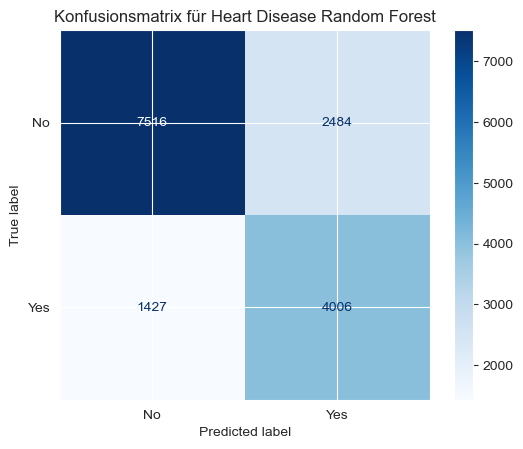

Accuracy: 0.7465819996112227
Precision: 0.6172573189522342
Recall: 0.7373458494386159
F1-Score: 0.6719785288937348


In [67]:

cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Random Forest')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_rand)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_rand)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_rand)
print("F1-Score:", f1)


### Fairness Analyse

In [68]:
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.766420   0.585744  0.640826  0.612048        0.314561
1    0.727423   0.635566  0.802029  0.709160        0.522863
Demographic Parity Difference: 0.208


### Relevanz der Daten nach Permutation

Age: 0.0848 ± 0.0033
GenHealth: 0.0296 ± 0.0027
Stroke: 0.0206 ± 0.0010
Sex: 0.0169 ± 0.0013
Diabetic: 0.0022 ± 0.0011
DiffWalking: 0.0015 ± 0.0007
KidneyDisease: 0.0011 ± 0.0007
Asthma: 0.0003 ± 0.0006
AlcoholDrinking: 0.0002 ± 0.0005
Smoking: -0.0001 ± 0.0011
MentalHealth: -0.0002 ± 0.0010
SkinCancer: -0.0002 ± 0.0006
SleepTime: -0.0006 ± 0.0011
BMI: -0.0008 ± 0.0012
PhysicalActivity: -0.0011 ± 0.0009
PhysicalHealth: -0.0013 ± 0.0012


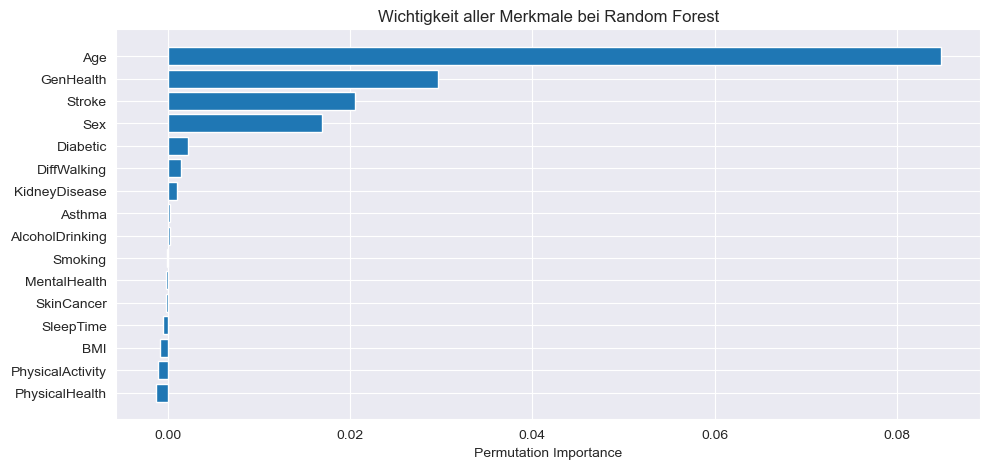

In [69]:
result = permutation_importance(best_forest_model, X_test, y_test, n_repeats=15, random_state=42, scoring='accuracy')
sorted_idx = result.importances_mean.argsort()[::-1]

for i in sorted_idx:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

plt.figure(figsize=(10, len(X_test.columns) * 0.3))  # Dynamische Höhe je nach Anzahl Features
plt.barh(X_test.columns[sorted_idx][::-1], result.importances_mean[sorted_idx][::-1])
plt.xlabel("Permutation Importance")
plt.title("Wichtigkeit aller Merkmale bei Random Forest")
plt.tight_layout()
plt.show()


### SHAP Analyse

In [70]:
X_sample = X_test.sample(n=1000, random_state=42)
explainer_rf = shap.TreeExplainer(best_model)
shap_values_rf = explainer_rf(X_sample, check_additivity=False)

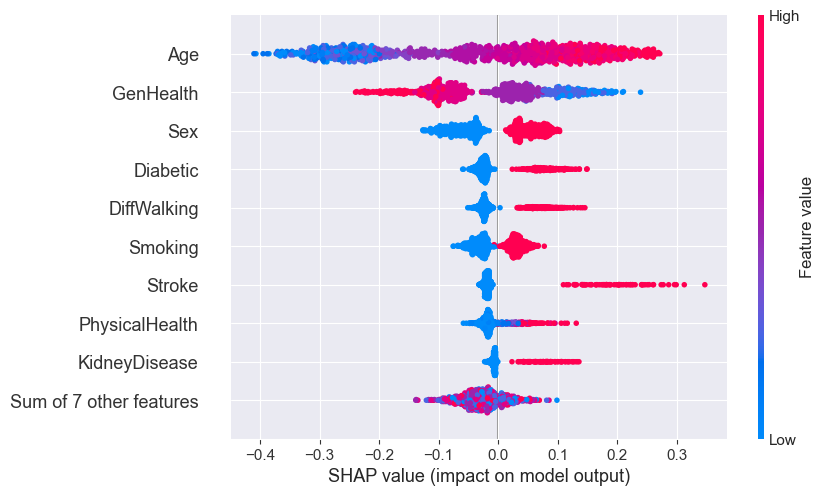

In [71]:
shap.plots.beeswarm(shap_values_rf[:, :, 1])

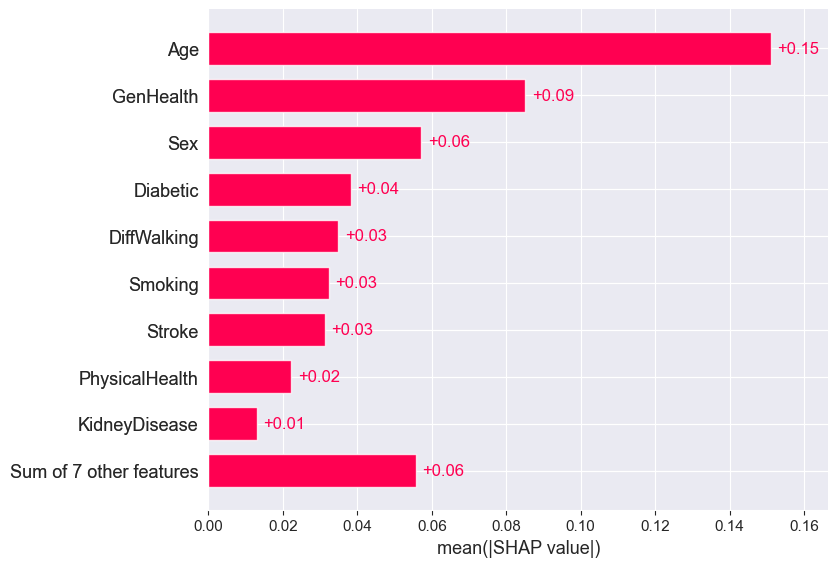

In [72]:
shap.plots.bar(shap_values_rf[:, :, 1])

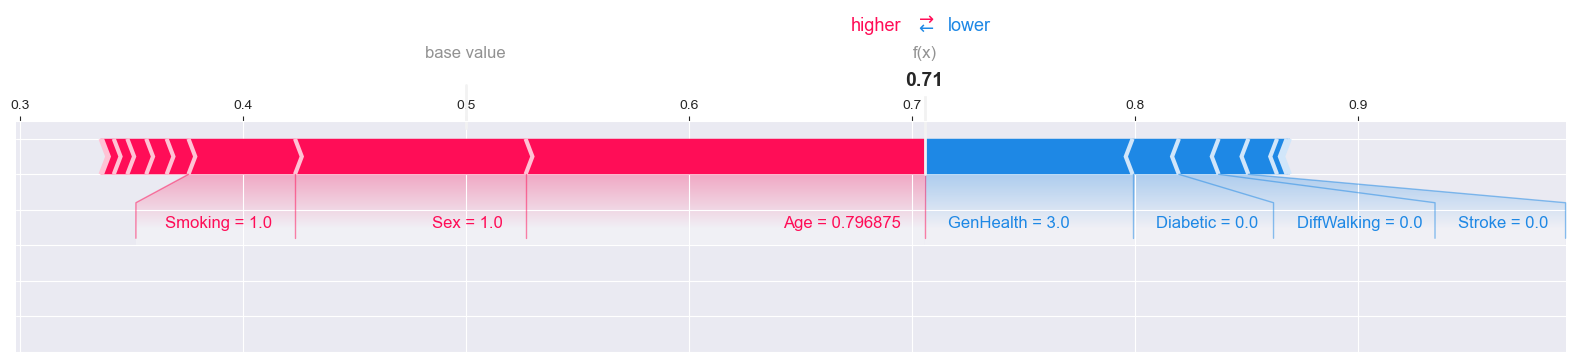

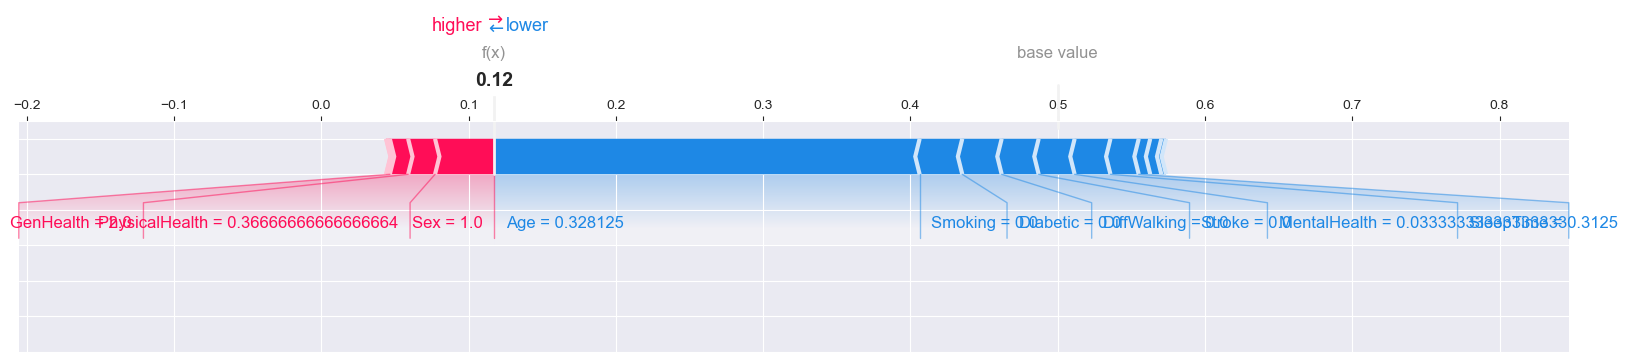

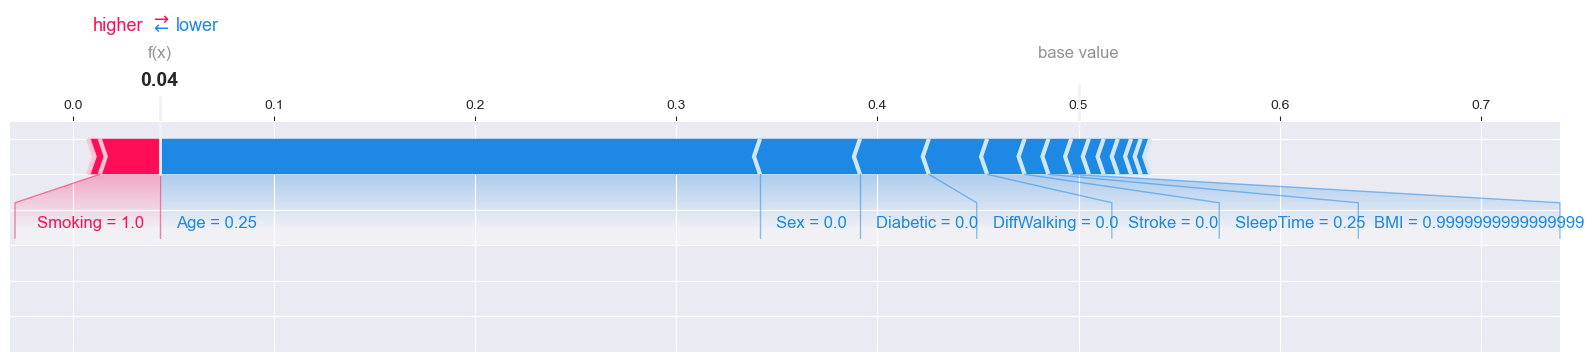

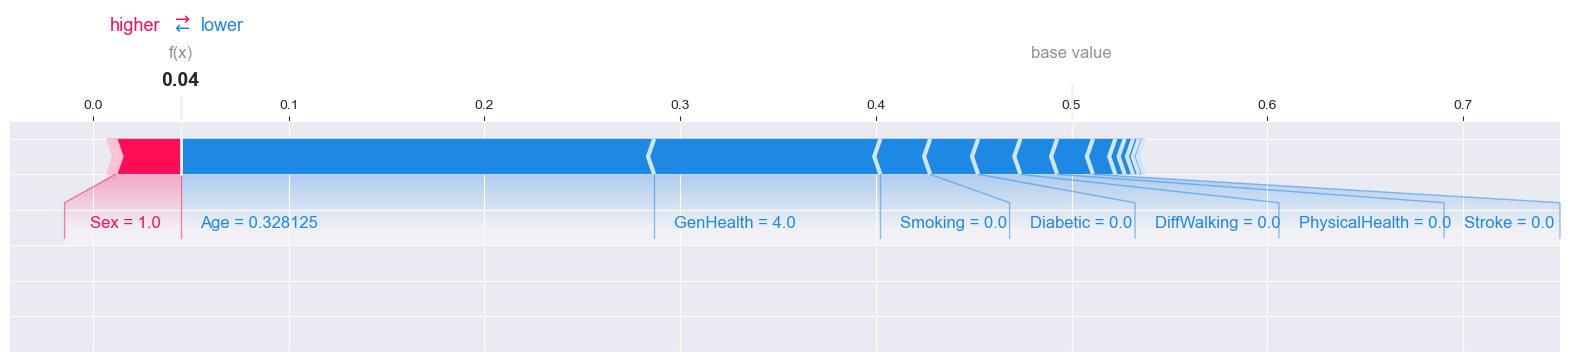

In [73]:
indices = [7, 8, 9, 10]

for i, index in enumerate(indices):
    shap.plots.force(shap_values_rf[index, :, 1], matplotlib=True)

## Stacking mit logistischer Regression und Random Forrest als Base Model, und LR als Meta Modell

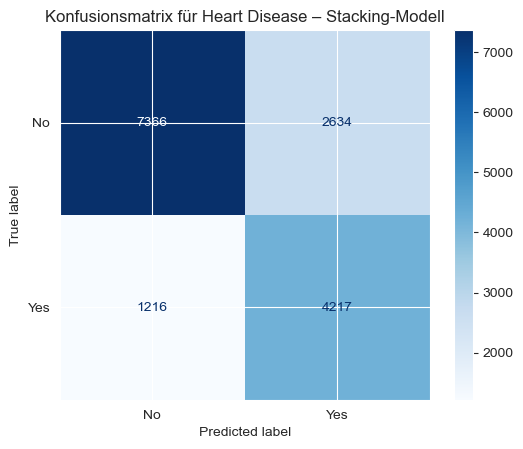

Genauigkeit (Stacking): 0.7505345687811832

Fairness-Analyse nach 'Sex' (Stacking):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.766684   0.579069  0.690367  0.629839        0.342786
1    0.734938   0.637817  0.833692  0.722718        0.541587
Demographic Parity Difference: 0.199


In [74]:
#Stacking lr und rf als base model, lr als meta

# Basismodelle (schon trainiert mit SMOTE)
estimators = [
    ('rf', best_forest_model),
    ('lr', modelLogistic)
]

# Meta-Modell: Logistische Regression
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stacking-Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,  # wenn True werden auch Original-Features aus dem Meta-Modell übergeben
    n_jobs=-1
)

# Stacking-Modell (smote Trainingsdaten)
stacked_model.fit(X_train, y_train)

#  Vorhersage auf Testdaten
y_pred_stack = stacked_model.predict(X_test)


# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – Stacking-Modell')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit (Stacking):", accuracy)

# Fairness-Analyse
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (Stacking):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

## XGB Boost

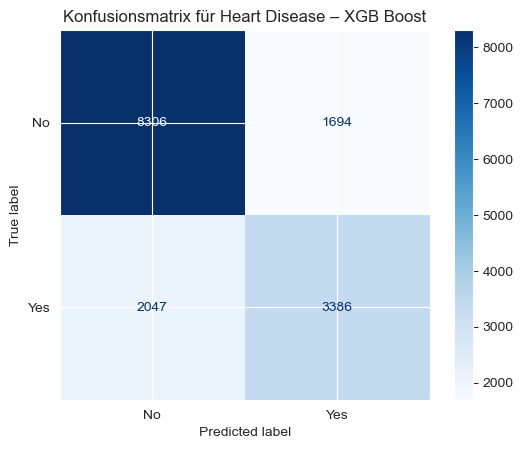

Accuracy: 0.7575973563143913
Precision: 0.6665354330708662
Recall: 0.6232284189214062
F1-Score: 0.6441548558927043


In [75]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – XGB Boost')
plt.show()

accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_xgb)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_xgb)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_xgb)
print("F1-Score:", f1)

### Fairness Analyse nach Geschlecht

In [76]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (XGB Boost):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Fairness-Analyse nach 'Sex' (XGB Boost):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.766684   0.579069  0.690367  0.629839        0.342786
1    0.734938   0.637817  0.833692  0.722718        0.541587
Demographic Parity Difference: 0.199


### Relevanz der Daten nach Permutation Importance

Age: 0.0675 ± 0.0023
GenHealth: 0.0295 ± 0.0026
Stroke: 0.0183 ± 0.0008
Sex: 0.0168 ± 0.0014
KidneyDisease: 0.0031 ± 0.0005
Diabetic: 0.0030 ± 0.0010
Smoking: 0.0027 ± 0.0011
DiffWalking: 0.0015 ± 0.0010
PhysicalHealth: 0.0012 ± 0.0008
AlcoholDrinking: 0.0008 ± 0.0006
BMI: 0.0004 ± 0.0010
PhysicalActivity: 0.0003 ± 0.0008
SkinCancer: 0.0001 ± 0.0005
Asthma: 0.0000 ± 0.0008
MentalHealth: -0.0001 ± 0.0009
SleepTime: -0.0019 ± 0.0013


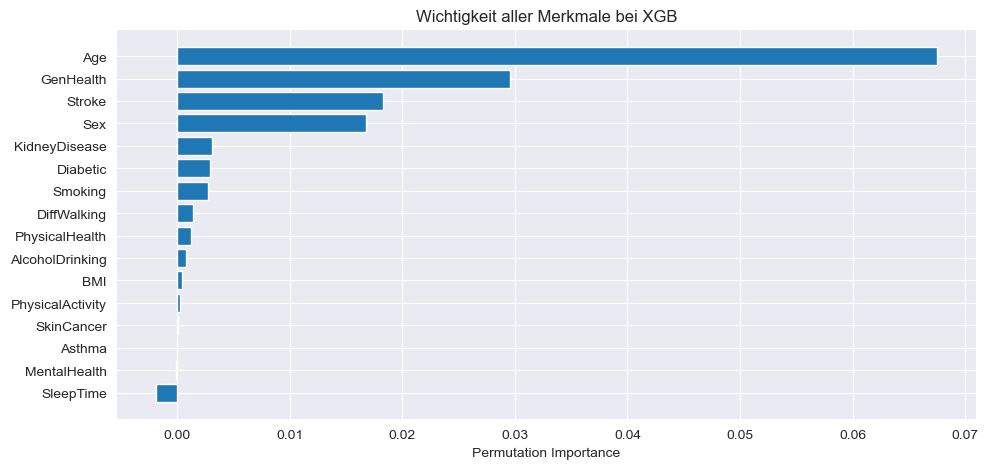

In [87]:
result = permutation_importance(xgb_model, X_test, y_test, n_repeats=15, random_state=42, scoring='accuracy')
sorted_idx = result.importances_mean.argsort()[::-1]

for i in sorted_idx:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

plt.figure(figsize=(10, len(X_test.columns) * 0.3))  # Dynamische Höhe je nach Anzahl Features
plt.barh(X_test.columns[sorted_idx][::-1], result.importances_mean[sorted_idx][::-1])
plt.xlabel("Permutation Importance")
plt.title("Wichtigkeit aller Merkmale bei XGB")
plt.tight_layout()
plt.show()

### Shap Analyse

100%|===================| 15432/15433 [00:44<00:00]        

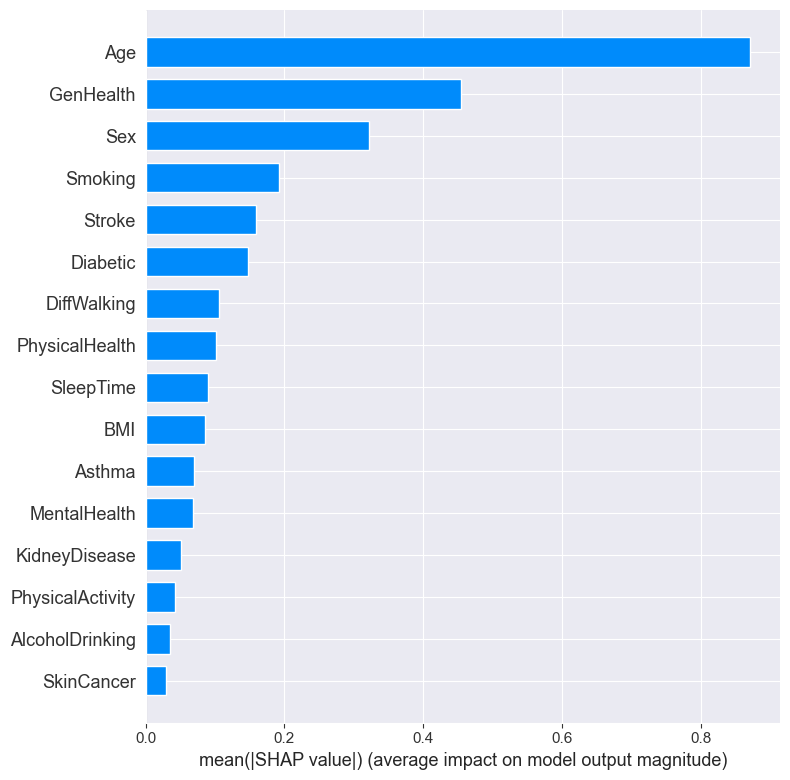

In [77]:
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)

shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

## Stacking mit logistischer Regression, Random Forrest und XG boost als Base Model, und LR als Meta Modell

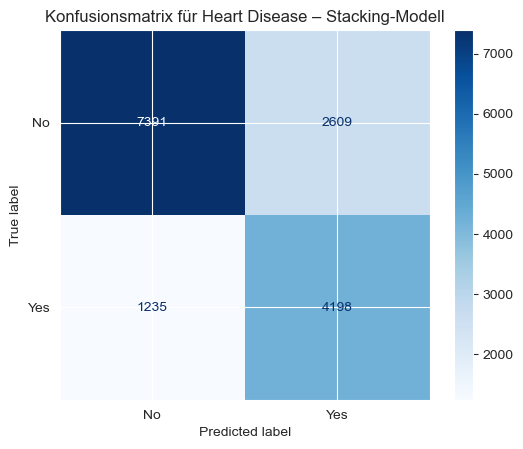

Accuracy: 0.7509233460765892
Precision: 0.6167180843249596
Recall: 0.7726854408245905
F1-Score: 0.6859477124183007


In [78]:
estimators = [
    ('rf', best_forest_model),
    ('lr', modelLogistic),
    ('xgb', xgb_model)
]

# Meta-Modell: Logistische Regression
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stacking-Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,  # wenn True werden auch Original-Features aus dem Meta-Modell übergeben
    n_jobs=-1
)

# Stacking-Modell ()
stacked_model.fit(X_train, y_train)

#  Vorhersage auf Testdaten
y_pred_stack = stacked_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – Stacking-Modell')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_stack)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_stack)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_stack)
print("F1-Score:", f1)

### Fairness Analyse

In [79]:

# Fairness-Analyse
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (Stacking):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Fairness-Analyse nach 'Sex' (Stacking):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0     0.76708   0.580482  0.684862  0.628367        0.339224
1     0.73532   0.638725  0.831540  0.722489        0.539422
Demographic Parity Difference: 0.200


### Impact der einzelnen Modelle

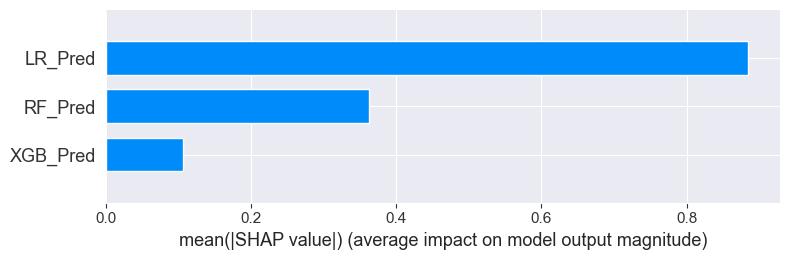

In [80]:
rf_pred = best_forest_model.predict_proba(X_test)[:, 1]
lr_pred = modelLogistic.predict_proba(X_test)[:, 1]
xgb_pred = xgb_model.predict_proba(X_test)[:, 1]

meta_features = np.column_stack((rf_pred, lr_pred, xgb_pred))

explainer = shap.Explainer(stacked_model.final_estimator_, meta_features)
shap_values = explainer(meta_features)
feature_names = ["RF_Pred", "LR_Pred", "XGB_Pred"]
shap.summary_plot(shap_values, features=meta_features, feature_names=feature_names, plot_type="bar")

## Voting

### Hart Voting

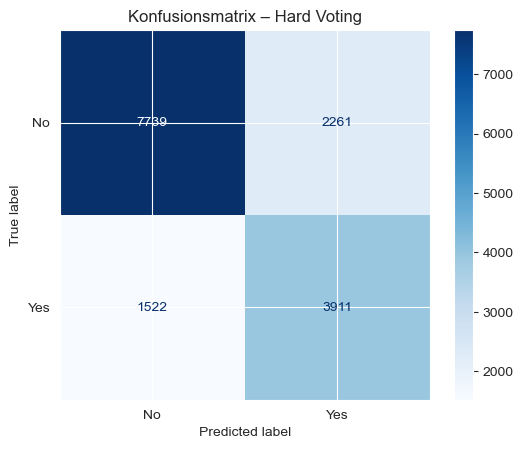

In [81]:
from sklearn.ensemble import VotingClassifier

voting_model_hard = VotingClassifier(
    estimators=[
        ('rf', best_forest_model),
        ('lr', modelLogistic),
        ('xgb', xgb_model)
    ],
    voting='hard',
    n_jobs=-1
)

voting_model_hard.fit(X_train, y_train)

y_pred_hard = voting_model_hard.predict(X_test)

cm_hard = confusion_matrix(y_test, y_pred_hard)
disp_hard = ConfusionMatrixDisplay(confusion_matrix=cm_hard, display_labels=['No', 'Yes'])
disp_hard.plot(cmap='Blues')
plt.title("Konfusionsmatrix – Hard Voting")
plt.show()

### Soft voting

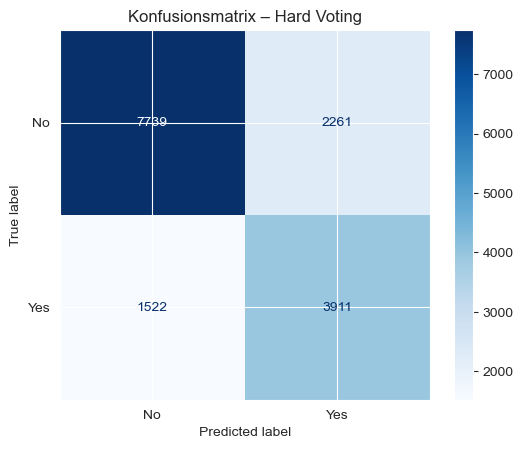

In [82]:
voting_model_soft = VotingClassifier(
    estimators=[
        ('rf', best_forest_model),
        ('lr', modelLogistic),
        ('xgb', xgb_model)
    ],
    voting='soft',
    n_jobs=-1
)

voting_model_soft.fit(X_train, y_train)

y_pred_soft = voting_model_hard.predict(X_test)

y_proba_soft = voting_model_soft.predict_proba(X_test)[:, 1]

cm_soft = confusion_matrix(y_test, y_pred_soft)
disp_soft = ConfusionMatrixDisplay(confusion_matrix=cm_soft, display_labels=['No', 'Yes'])
disp_soft.plot(cmap='Blues')
plt.title("Konfusionsmatrix – Hard Voting")
plt.show()

### Vergleich Hart und Soft

In [83]:
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate(name, y_true, y_pred, y_prob=None):
    print(f" {name}")
    print(f"  Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"  F1 Score:  {f1_score(y_true, y_pred):.4f}")
    if y_prob is not None:
        print(f"  AUC:       {roc_auc_score(y_true, y_prob):.4f}")
    print()

evaluate("Hard Voting", y_test, y_pred_hard)
evaluate("Soft Voting", y_test, y_pred_soft, y_proba_soft)


 Hard Voting
  Accuracy:  0.7549
  Precision: 0.6337
  Recall:    0.7199
  F1 Score:  0.6740

 Soft Voting
  Accuracy:  0.7549
  Precision: 0.6337
  Recall:    0.7199
  F1 Score:  0.6740
  AUC:       0.8320



# Vergleich Merkmale 3 Modell

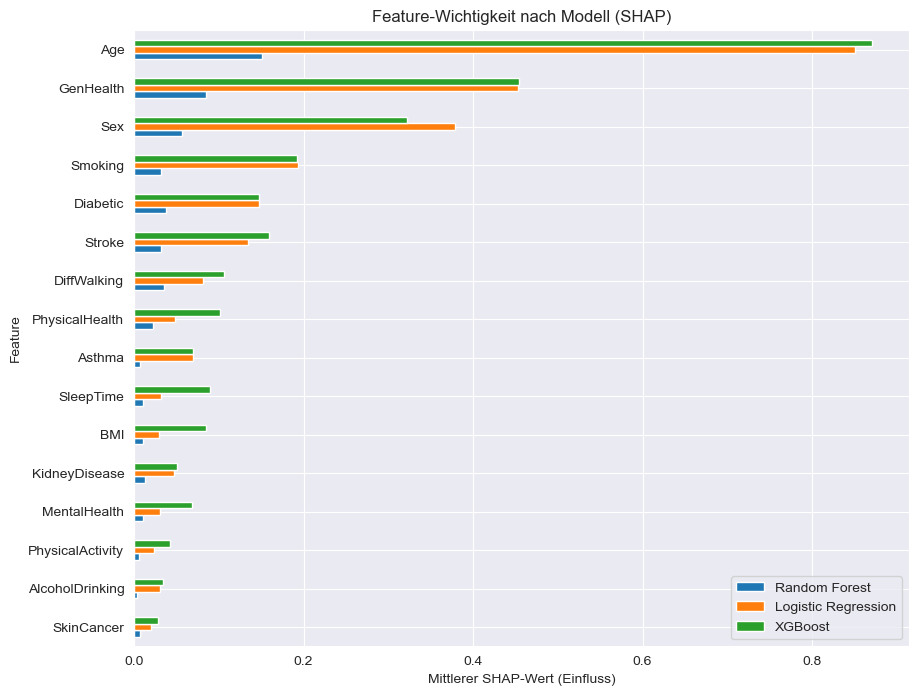

In [84]:

mean_rf = np.abs(shap_values_rf.values[:, :, 1]).mean(axis=0)
mean_lr = np.abs(shap_values_lr.values).mean(axis=0)
mean_xgb = np.abs(shap_values_xgb.values).mean(axis=0)

shap_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Random Forest": mean_rf,
    "Logistic Regression": mean_lr,
    "XGBoost": mean_xgb
}).set_index("Feature")


shap_df["Mean"] = shap_df.mean(axis=1)
shap_df = shap_df.sort_values("Mean")

shap_df.drop(columns="Mean").plot(kind="barh", figsize=(10, 8), title="Feature-Wichtigkeit nach Modell (SHAP)")
plt.xlabel("Mittlerer SHAP-Wert (Einfluss)")
plt.show()


# Erklärbarkeit auf eine Person

Index der ausgewählten Person: 3342
Vorhersagen für eine Testperson:
Random Forest:           Keine Krankheit
Logistische Regression:  Keine Krankheit
XGBoost:                 Keine Krankheit
Voting:                  Keine Krankheit
Wahrer Wert:             Keine Krankheit


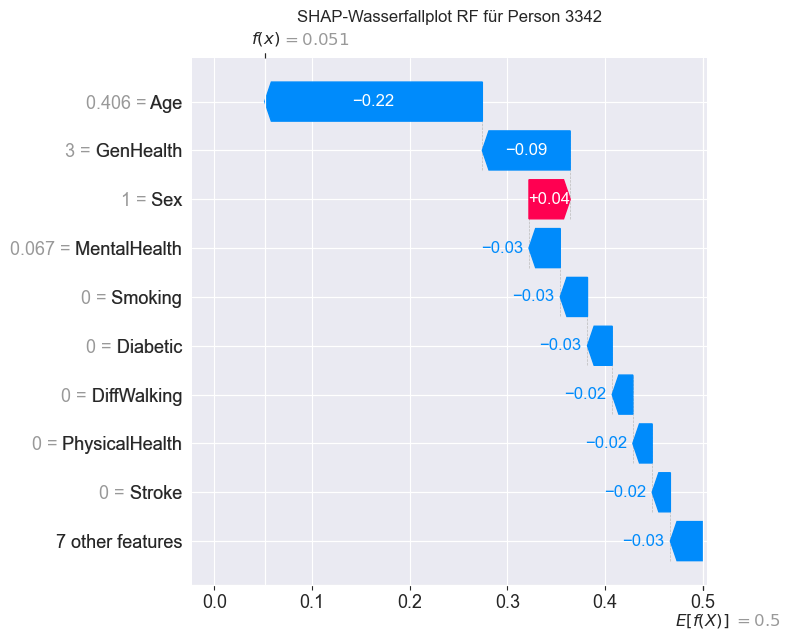

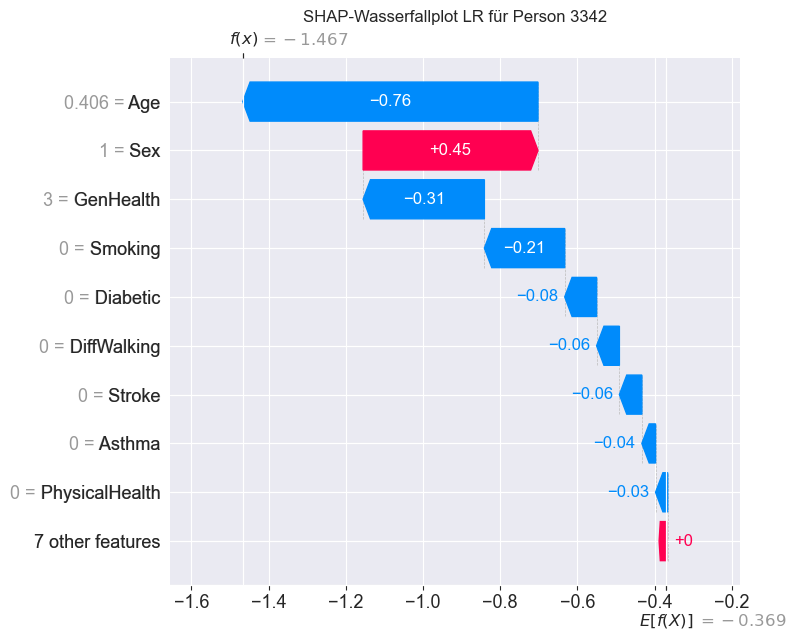

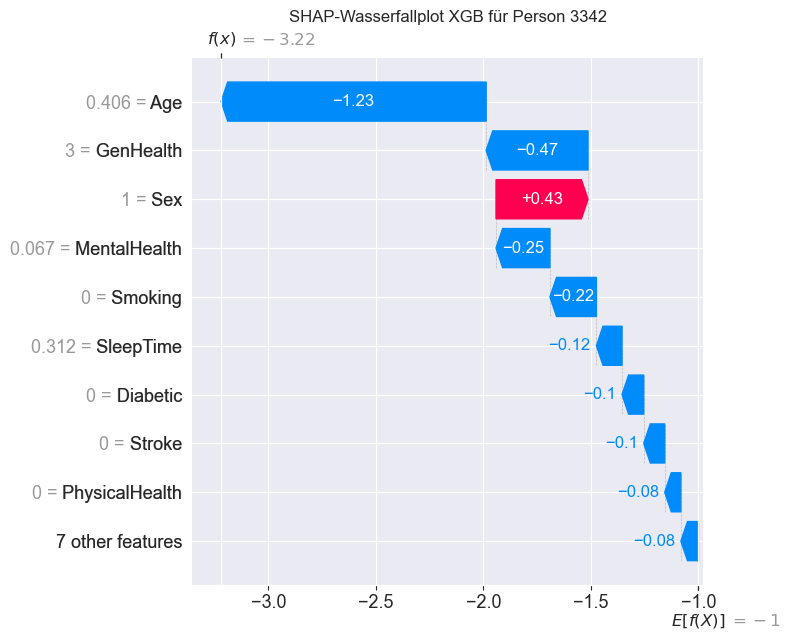

In [85]:
import random

idx = random.randint(0, X_test.shape[0] - 1)
#idx = 13
print(f"Index der ausgewählten Person: {idx}")
person = X_test.iloc[[idx]]

# Vorhersagen
pred_rf = best_forest_model.predict(person)[0]
pred_lr = modelLogistic.predict(person)[0]
pred_xgb = xgb_model.predict(person)[0]
pred_voting = voting_model_soft.predict(person)

print("Vorhersagen für eine Testperson:")
print(f"Random Forest:           {'Krankheit' if pred_rf == 1 else 'Keine Krankheit'}")
print(f"Logistische Regression:  {'Krankheit' if pred_lr == 1 else 'Keine Krankheit'}")
print(f"XGBoost:                 {'Krankheit' if pred_xgb == 1 else 'Keine Krankheit'}")
print(f"Voting:                  {'Krankheit' if pred_voting == 1 else 'Keine Krankheit'}")


true_label = y_test.iloc[idx]
print(f"Wahrer Wert:             {'Krankheit' if pred_rf == 1 else 'Keine Krankheit'}")

shap_val_rf = explainer_rf(person)
shap_val_lr = explainer_lr(person)
shap_val_xgb = explainer_xgb(person)


fig, ax = plt.subplots(figsize=(10, 15))
shap.plots.waterfall(shap_val_rf[0, :, 1], max_display=10, show=False)  # wichtig: show=False
plt.title(f"SHAP-Wasserfallplot RF für Person {idx}")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 15))
shap.plots.waterfall(shap_val_lr[0], max_display=10, show=False)
plt.title(f"SHAP-Wasserfallplot LR für Person {idx}")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 15))
shap.plots.waterfall(shap_val_xgb[0], max_display=10, show=False)
plt.title(f"SHAP-Wasserfallplot XGB für Person {idx}")
plt.tight_layout()
plt.show()
